# AOMA with Poly reference Least Squares Complex Frequency-domain estimator - Single period

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from scipy import signal
import dataloader_halogaland.dataloader as dl
#from dataloader_halogaland.processer import welch_plot
import os
import koma.oma, koma.plot
import koma.clustering
from time import time
import pandas as pd
from dataloader_halogaland.plot import stabilization_diagram
import strid
from time import time

/Users/emilneby/miniforge3/envs/master/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
analysis_length = 30 #minutes
cutoff_frequency = 1 #Hz

loader= loader= dl.HDF5_dataloader(os.getcwd()+'/../../../../../../../Volumes/LaCie/Halogaland_sixth_try.hdf5')

Available accelerometers: ['A01-1', 'A03-1', 'A03-2', 'A04-1', 'A04-2', 'A05-1', 'A05-2', 'A06-1', 'A06-2', 'A06-3', 'A06-4', 'A07-1', 'A07-2', 'A08-1', 'A08-2', 'A08-3', 'A08-4', 'A09-1', 'A09-2', 'A10-1', 'A10-2', 'A11-1']


In [3]:
acc = loader.load_all_acceleration_data(loader.periods[12], preprosess=True, cutoff_frequency=cutoff_frequency, filter_order=10)
print(acc.shape)
acc = acc[:2*cutoff_frequency*60*analysis_length,:]
print(acc.shape)

(57600, 66)
(3600, 66)


## System identification with Poly reference Least Squares Complex Frequency-domain estimator

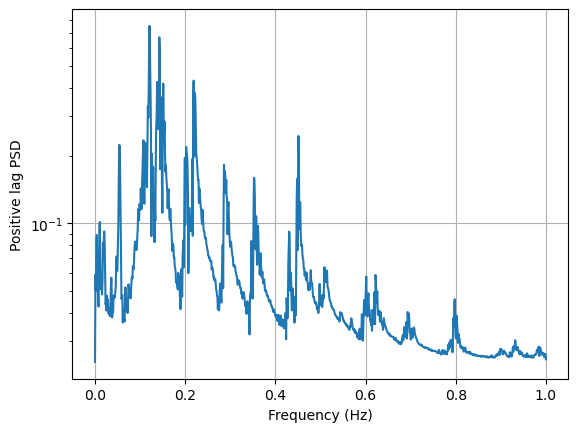

In [4]:
fs = 2
Syyp = strid.find_positive_psd_matrix(acc.transpose(), acc.transpose(), nfft=2**11)

f = strid.get_frequency_vector(fs, Syyp.shape[2])

fig, ax = plt.subplots()
ax.semilogy(f, np.abs(np.trace(Syyp)))
ax.set(xlabel="Frequency (Hz)", ylabel="Positive lag PSD")
plt.grid()



In [5]:
fdid = strid.PolyReferenceLSCF(Syyp, fs)

In [ ]:
t0 = time()
nmax = 150

modes = {}
for i, order in enumerate(range(5, nmax+1)):
    N, D = fdid.perform(order, nmax)
    modes[order] = strid.Mode.find_modes_from_rmfd(N, D, fdid.fs)
t1 = time()
print("Execution time = " + str(t1-t0))

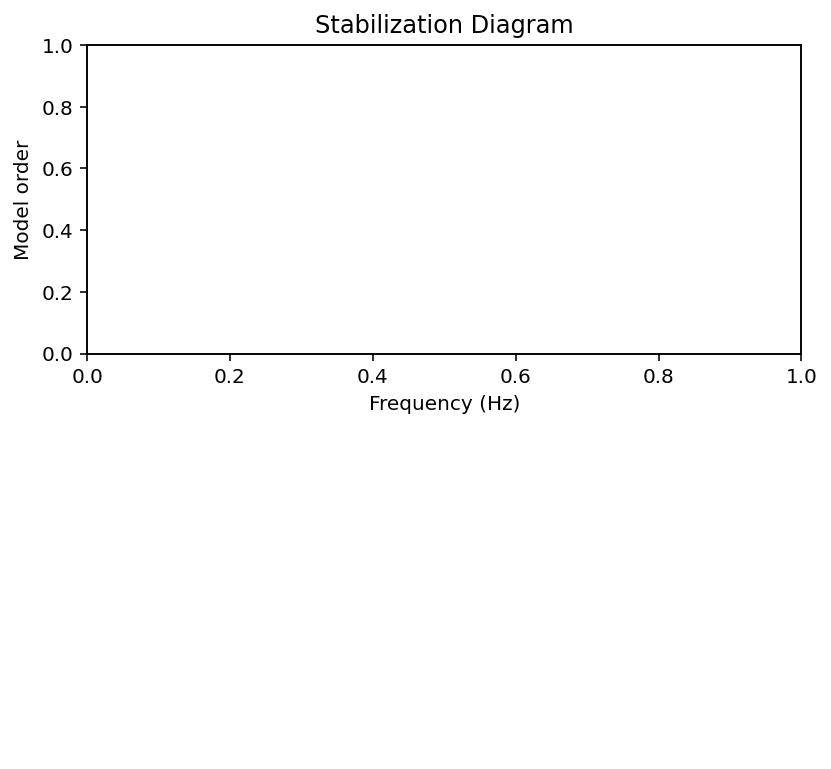

In [24]:
stabdiag = strid.StabilizationDiagram()
modes = stabdiag.filter_modes(modes)

In [25]:
orders = []
lambdas = []
phis = []

for order in modes.keys():
    modes_in_order = modes[order]
    for mode in modes_in_order:
        orders.append(order)
        lambdas.append(mode.eigenvalue)
        phis.append(mode.eigenvector)

orders = np.array(orders)
lambdas = np.array(lambdas)
phis = np.array(phis).transpose()

In [26]:
print(type(orders))
print(phis.shape)

<class 'numpy.ndarray'>
(66, 867)


## Clustering with HDBSCAN

In [27]:
#Pole clustering
pole_clusterer = koma.clustering.PoleClusterer(lambdas, phis, orders, min_cluster_size=10, min_samples=10, scaling={'mac':1.0, 'lambda_real':0.7, 'lambda_imag': 0.5})
prob_threshold = 0.5   #probability of pole to belong to cluster, based on estimated "probability" density function
args = pole_clusterer.postprocess(prob_threshold=prob_threshold, normalize_and_maxreal=True)

xi_auto, omega_n_auto, phi_auto, order_auto, probs_auto, ixs_auto = koma.clustering.group_clusters(*args)

#plot_koma.plot_stab_from_KOMA(np.array(omega_n_auto)/2/np.pi, order_auto).savefig("results/realization_" + str(j) + ".jpg")

xi_mean = np.array([np.mean(xi_i) for xi_i in xi_auto])
fn_mean = np.array([np.mean(om_i) for om_i in omega_n_auto])/2/np.pi

xi_std = np.array([np.std(xi_i) for xi_i in xi_auto])
fn_std = np.array([np.std(om_i) for om_i in omega_n_auto])/2/np.pi

In [28]:
### Creating a Stabilization diagram

/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_18618/3192336573.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc, fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambdas)/2/np.pi, all_orders=orders)


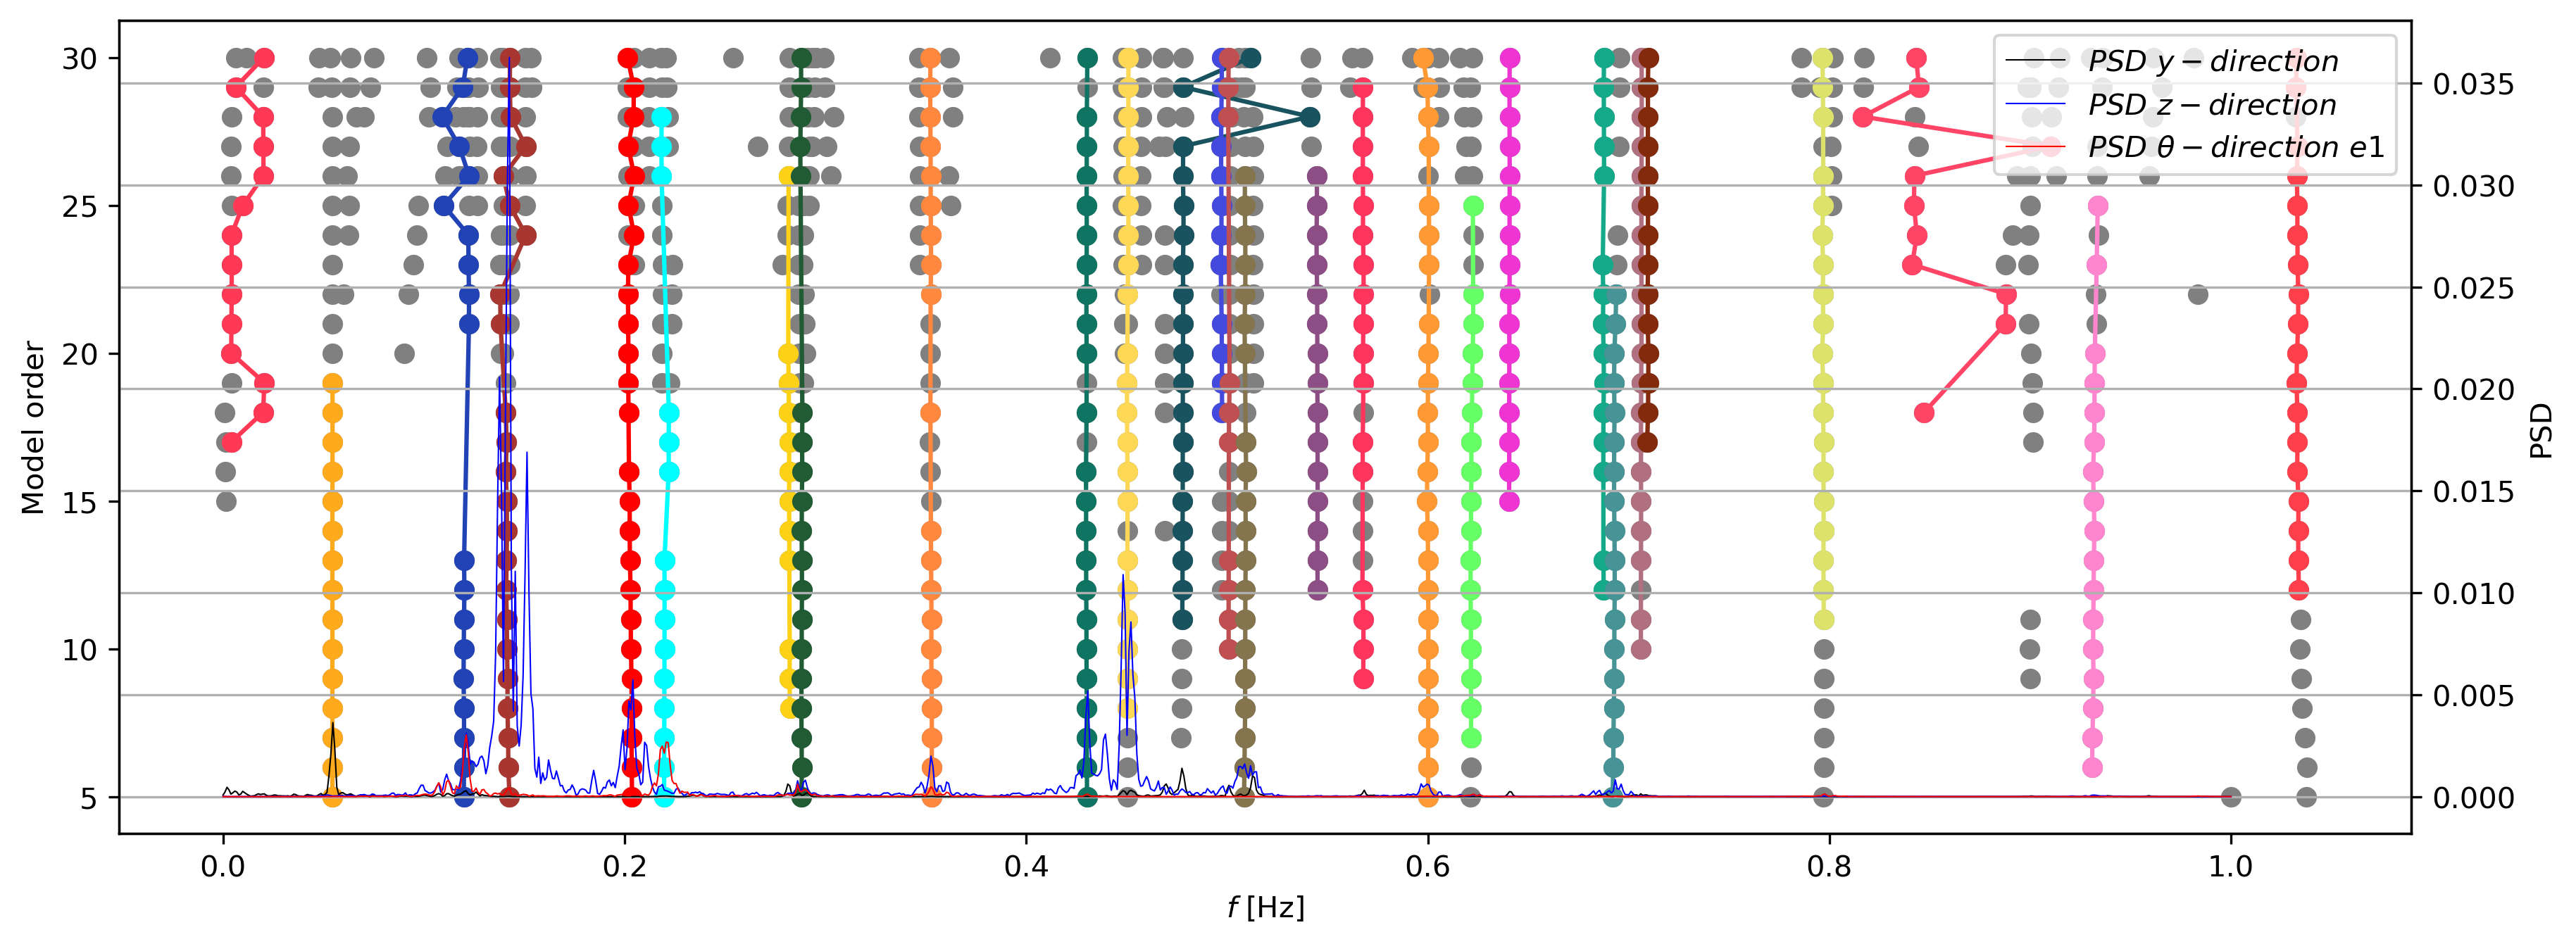

In [29]:
stab_diag = stabilization_diagram(acc, fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambdas)/2/np.pi, all_orders=orders)
plt.savefig("stabilization_diagram.jpg")

In [30]:
# Print table
import pandas as pd
res_data = np.vstack([fn_mean, 100*xi_mean]).T
results = pd.DataFrame(res_data, columns=['$f_n$ [Hz]', r'$\xi$ [%]'])
results

,$f_n$ [Hz],$\xi$ [%]
0,0.011591,3.790680
1,0.054470,1.298505
2,0.119426,0.603752
3,0.142139,0.886757
4,0.202828,0.545383
5,0.219934,0.408016
6,0.281910,0.030881
7,0.288090,0.573708
8,0.352588,0.384832
9,0.430058,0.261848
